## 处理数据

In [63]:
import pandas as pd
import numpy as np
import tensorflow.compat.v1 as tf
from matplotlib import pyplot as plt
%matplotlib inline

In [30]:
ratings_df = pd.read_csv('ml-latest-small/ratings.csv')
ratings_df.tail()

,userId,movieId,rating,timestamp
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352
100835,610,170875,3.0,1493846415


In [31]:
movies_df = pd.read_csv('ml-latest-small/movies.csv')
movies_df.tail()

,movieId,title,genres
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation
9741,193609,Andrew Dice Clay: Dice Rules (1991),Comedy


In [32]:
movies_df['movie_row'] = movies_df.index
movies_df.tail()

,movieId,title,genres,movie_row
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,9737
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,9738
9739,193585,Flint (2017),Drama,9739
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,9740
9741,193609,Andrew Dice Clay: Dice Rules (1991),Comedy,9741


In [33]:
movies_df = movies_df.iloc[:,[0,1,3]]
movies_df.to_csv('moviesProcessed.csv',index=False,header = True,encoding = 'utf-8')
movies_df.tail()

,movieId,title,movie_row
9737,193581,Black Butler: Book of the Atlantic (2017),9737
9738,193583,No Game No Life: Zero (2017),9738
9739,193585,Flint (2017),9739
9740,193587,Bungo Stray Dogs: Dead Apple (2018),9740
9741,193609,Andrew Dice Clay: Dice Rules (1991),9741


In [34]:
ratings_df = pd.merge(ratings_df,movies_df,on='movieId')
ratings_df.head()

,userId,movieId,rating,timestamp,title,movie_row
0,1,1,4.0,964982703,Toy Story (1995),0
1,5,1,4.0,847434962,Toy Story (1995),0
2,7,1,4.5,1106635946,Toy Story (1995),0
3,15,1,2.5,1510577970,Toy Story (1995),0
4,17,1,4.5,1305696483,Toy Story (1995),0


In [35]:
ratings_df = ratings_df.iloc[:,[5,0,2]]
ratings_df.to_csv('ratingsProcessed.csv',index = False,header = True, encoding = 'utf-8')
ratings_df.head()

,movie_row,userId,rating
0,0,1,4.0
1,0,5,4.0
2,0,7,4.5
3,0,15,2.5
4,0,17,4.5


<AxesSubplot:ylabel='Frequency'>

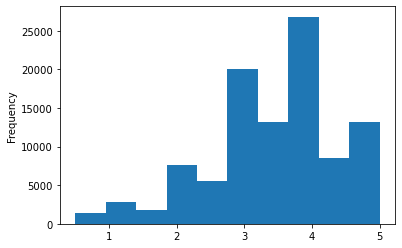

In [36]:
ratings_df['rating'].plot.hist()

In [37]:
userNo = ratings_df['userId'].max()+1
movieNo = ratings_df['movie_row'].max()+1
print(userNo)
print(movieNo)

611
9742


In [41]:
rating = np.zeros((movieNo,userNo))
flag = 0
ratings_df_length = np.shape(ratings_df)[0]
#以电影为行，用户为列构建评分矩阵
for index, row in ratings_df.iterrows():
    rating[int(row['movie_row']), int(row['userId'])] = row['rating'] 
    flag += 1 # 处理完一行
    if flag%5000 == 0:
        print('processed %d, %d left' % (flag, ratings_df_length-flag)) 
# 记录有评分的数据，rating里0分表示没有评分，有评分则用1表示，构建布尔类型矩阵
record = rating > 0
record = np.array(record, dtype=int)

processed 5000, 95836 left
processed 10000, 90836 left
processed 15000, 85836 left
processed 20000, 80836 left
processed 25000, 75836 left
processed 30000, 70836 left
processed 35000, 65836 left
processed 40000, 60836 left
processed 45000, 55836 left
processed 50000, 50836 left
processed 55000, 45836 left
processed 60000, 40836 left
processed 65000, 35836 left
processed 70000, 30836 left
processed 75000, 25836 left
processed 80000, 20836 left
processed 85000, 15836 left
processed 90000, 10836 left
processed 95000, 5836 left
processed 100000, 836 left


In [42]:
#检查一下有没有缺失
print(np.sum(record>0))

100836


## 构建模型

In [59]:
def normalizeRatings(rating, record):
    m, n = rating.shape
    rating_mean = np.zeros((m, 1)) # 所有电影平均评分初始化为0
    rating_norm = np.zeros((m, n)) # 保存处理之后的数据
    for i in range(m):
        idx = record[i, :] != 0 # 已评分的电影对应的用户下标
        rating_mean[i] = np.mean(rating[i, idx]) #第i部电影的平均分
        rating_norm[i, idx] = rating[i, idx] - rating_mean[i] # 原始评分减去评分的平均值
    return rating_norm, rating_mean
rating_norm, rating_mean = normalizeRatings(rating, record)
rating_norm = np.nan_to_num(rating_norm)
rating_mean = np.nan_to_num(rating_mean)

In [60]:
print(np.sum([rating_norm == np.nan]))

0


In [74]:
num_features = 10
X_para = tf.Variable(tf.random_normal([movieNo, num_features], stddev = 0.4))
Theta_para = tf.Variable(tf.random_normal([userNo, num_features], stddev = 0.4))
k = 1 #正则项常数
def loss():
     return (1/2 * tf.reduce_sum(((tf.matmul(X_para, Theta_para, transpose_b=True) - rating_norm) * record) ** 2) + k/2 * (tf.reduce_sum(X_para ** 2) + tf.reduce_sum(Theta_para ** 2)))
optimizer = tf.train.AdamOptimizer(1e-4)
train = optimizer.minimize(loss)

In [73]:
tf.summary.scalar('loss',loss())
Merged = tf.summary.merge_all()
filename = './movie_tensorboard'
writer = tf.summary.FileWriter(filename)
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
for i in range(5000):
    _, movie_summary = sess.run([train, Merged])
    writer.add_summary(movie_summary, i)

RuntimeError: Merging tf.summary.* ops is not compatible with eager execution. Use tf.contrib.summary instead.

In [50]:
N_X_para, N_Theta_para = sess.run([X_para, Theta_para])
predict = np.dot(N_X_para, N_Theta_para.T) + rating_mean
predict = np.nan_to_num(predict)
print(np.sum(predict == np.nan))
print(np.sum(rating == np.nan))
errors = np.sqrt(np.sum((predict-rating)**2))
print(errors)

NameError: name 'sess' is not defined

In [128]:
print(predict)

[[3.74254715 4.78006354 4.2178753  ... 3.42583143 3.72582896 4.68493273]
 [3.43137385 3.74881032 3.83070188 ... 2.6766799  2.93178123 3.98571473]
 [3.46280142 3.84487572 3.1575341  ... 2.95256745 3.25588668 3.16737926]
 ...
 [3.24940735 3.75448602 3.61399497 ... 3.51277474 3.52528687 3.95782039]
 [3.59122005 3.30389871 3.53419799 ... 3.38063141 3.34504196 3.51227614]
 [3.83619021 4.16188315 3.90032429 ... 3.8430018  3.9545262  4.43670759]]


## 推荐

In [1]:
user_id = input("请输入用户编号：")
RecoList = predict[:,int(user_id)].argsort()[::-1]
idx = 0
print("推荐列表生成：")
print('-'*50)
for i in RecoList:
    print('电影：{:s}，预测可能评分：{:.2f}'.format(movies_df.iloc[i]['title'],predict[i, int(user_id)]))
    idx += 1
    if idx == 20:
        break

请输入用户编号：201


NameError: name 'predict' is not defined